In [1]:
import os
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import Audio
import numpy as np
import pandas as pd
import pickle
import yaml

from lib.notebooks import plot_groups_metrics
from communicative_agent import CommunicativeAgent

In [2]:
agents_path = glob("../out/communicative_agent/*/")
agents_path.sort()

In [3]:
groups_metrics = {}
agents_loss = {
    "path": [],
    "datasets": [],
    "inverse_learning_rate": [],
    "inverse_layers": [],
    "inverse_dropout_p": [],
    "direct_learning_rate": [],
    "direct_layers": [],
    "direct_dropout_p": [],
    "jerk_weight": [],
    "direct_estimation_error": [],
    "inverse_estimation_error": [],
    "jerk": [],
    "repetition_error": [],
    "discrimination_accuracy": [],
    "discrimination_loss": [],
    "fool_discrimination_loss": [],
}

for agent_path in agents_path:
    agent = CommunicativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
    with open("%s/metrics.pickle" % agent_path, "rb") as f:
        metrics = pickle.load(f)
    
    agents_loss["path"].append(agent_path[-5:-1])
    agents_loss["datasets"].append(",".join(agent.sound_quantizer.config['dataset']['names']))

    agents_loss["inverse_learning_rate"].append(config['training']['inverse_model_learning_rate'])
    agents_loss["inverse_layers"].append(f"{config['model']['inverse_model']['num_layers']}x{config['model']['inverse_model']['hidden_size']}")
    agents_loss["inverse_dropout_p"].append(config['model']['inverse_model']['dropout_p'])

    if 'use_synth_as_direct_model' not in config['model']:
        agents_loss["direct_learning_rate"].append(config['training']['direct_model_learning_rate'])
        agents_loss["direct_layers"].append(f"{len(config['model']['direct_model']['hidden_layers'])}x{config['model']['direct_model']['hidden_layers'][0]}")
        agents_loss["direct_dropout_p"].append(config['model']['direct_model']['dropout_p'])
    else:
        agents_loss["direct_learning_rate"].append(0)
        agents_loss["direct_layers"].append("synth")
        agents_loss["direct_dropout_p"].append(0)
    
    agents_loss["jerk_weight"].append(config['training']['jerk_loss_weight'])

    final_loss_index = np.argmin(metrics["validation"]["inverse_model_repetition_error"])
    
    
    if 'use_synth_as_direct_model' not in config['model']:
        agents_loss["direct_estimation_error"].append(metrics["test"]["direct_model_estimation_error"][final_loss_index])
    else:
        agents_loss["direct_estimation_error"].append(0)

    agents_loss["inverse_estimation_error"].append(metrics["test"]["inverse_model_estimation_error"][final_loss_index])
    agents_loss["jerk"].append(metrics["test"]["inverse_model_jerk"][final_loss_index])
    agents_loss["repetition_error"].append(metrics["test"]["inverse_model_repetition_error"][final_loss_index])
    
    group_name = "\n".join((
        f"datasets={','.join(agent.sound_quantizer.config['dataset']['names'])}",
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}",
        f"jerk_w={config['training']['jerk_loss_weight']}",
        # f"frame_padding={config['model']['sound_quantizer']['frame_padding']}",
    ))
    
    if group_name not in groups_metrics:
        groups_metrics[group_name] = {}
    groups_metrics[group_name][agent_path] = metrics

agents_loss = pd.DataFrame(agents_loss)

ValueError: All arrays must be of the same length

In [15]:
datasets = pd.unique(agents_loss["datasets"])
jerk_weights = pd.unique(agents_loss["jerk_weight"])

def show_top_agents(measure="repetition_error", datasets=datasets[0], jerk_weight=jerk_weights[0], use_synth_as_direct=False, ascending=True):
    subset = agents_loss[agents_loss["datasets"] == datasets]
    subset = subset[subset["jerk_weight"] == jerk_weight]
    if use_synth_as_direct:
        subset = subset[subset["direct_layers"] == "synth"]
    else:
        subset = subset[subset["direct_layers"] != "synth"]
    display(subset.sort_values(measure, ascending=ascending).head(30))

ipw.interactive(show_top_agents, measure=agents_loss, datasets=datasets, jerk_weight=jerk_weights, use_synth_as_direct=False, ascending=True)

interactive(children=(Dropdown(description='measure', index=12, options=('path', 'datasets', 'inverse_learning…

In [20]:
metrics_name = [
    # "sound_quantizer_reconstruction_error",
    # "sound_quantizer_vq_loss",
    "direct_model_estimation_error",
    "inverse_model_estimation_error",
    "inverse_model_repetition_error",
    #"inverse_model_jerk",
]

def show_metrics(split_name="test"):
    plot_groups_metrics(groups_metrics, metrics_name, split_name)
display(ipw.interactive(show_metrics, split_name=["train", "validation", "test"]))


interactive(children=(Dropdown(description='split_name', index=2, options=('train', 'validation', 'test'), val…

dict_keys(['datasets=pb2007\nsynth_art=art_params\njerk_w=0'])


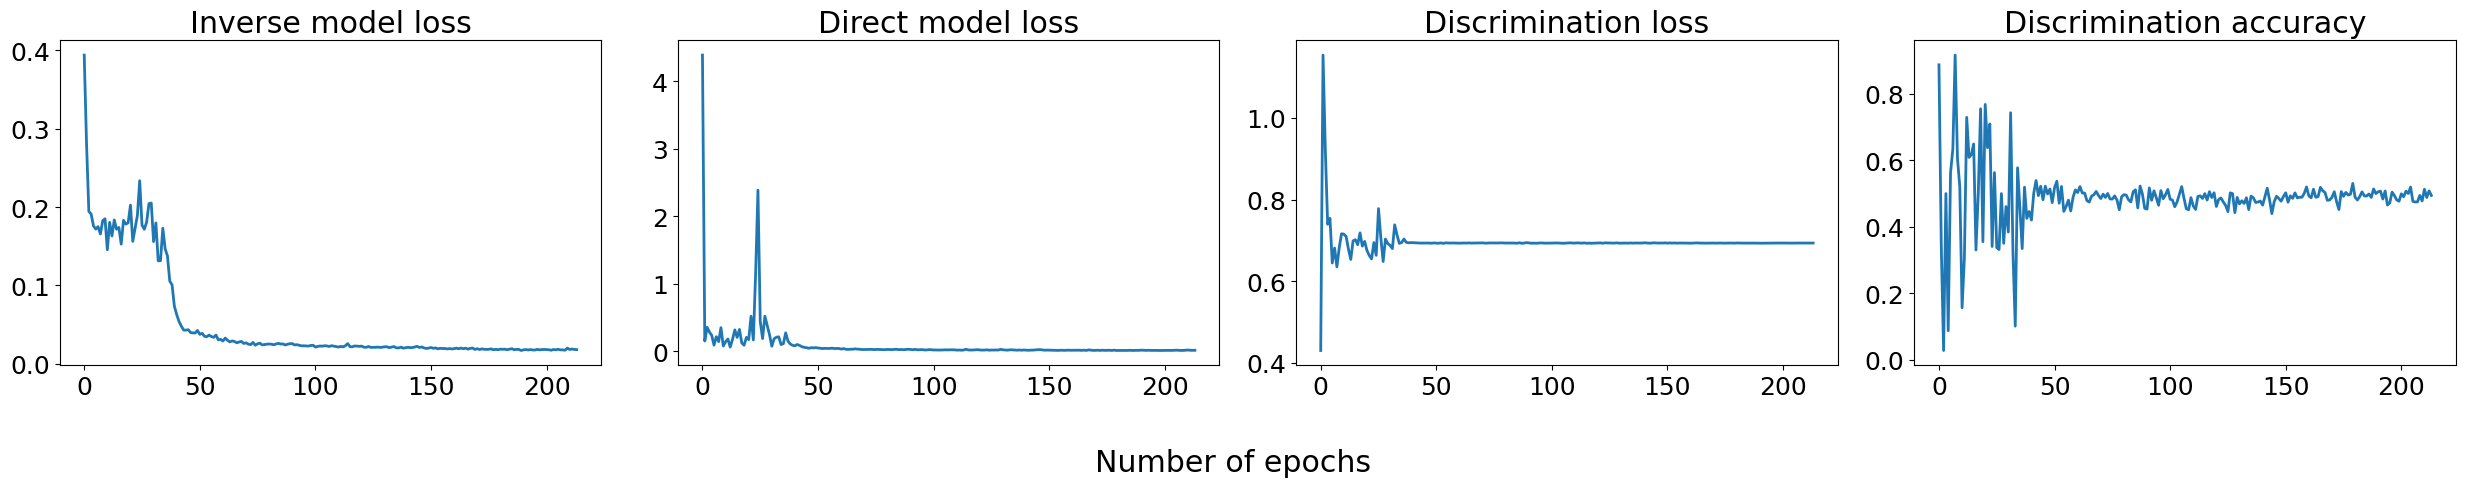

In [2]:
import matplotlib
import pickle
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 18, 'lines.linewidth': 2})

agent_path = "../out/communicative_agent/e6c450361f0e3b698a5a67e351d88061-0"
with open("%s/metrics.pickle" % agent_path, "rb") as f:
        metrics = pickle.load(f)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))
axs[0].set_title("Inverse model loss")
axs[0].plot(metrics["validation"]["inverse_model_estimation_error"])

axs[1].set_title("Direct model loss")
axs[1].plot(metrics["validation"]["direct_model_estimation_error"])

axs[2].set_title("Discrimination loss")
axs[2].plot(metrics["validation"]["discrimination_loss"])

axs[3].set_title("Discrimination accuracy")
axs[3].plot(metrics["validation"]["discrimination_accuracy"])

fig.supxlabel("Number of epochs")
plt.tight_layout()
plt.savefig(agent_path + '/losses.png', dpi=300)

In [5]:
from pathlib import Path
import yaml
import pickle
model_path = Path("../out/communicative_agent")
#basenames = ['e6c450361f0e3b698a5a67e351d88061-0', '0a421b2730388bfe6a4f784848001ee0-0', 
#             '1ef3a9d5ede77d6a17d942423832f9f6-0', '9ce302262395417796a1f42f8e4449ba-0',
#             '152faa7ab54272089722dd2989724ea6-0']
#basenames = ['188cb52ac1fc23257dba472730c07ba7-0',
#             'b8c532ecf618116ad1f06d5a341da3ae-0',
#             '22e9cdcab1563dd5a97cce718987db69-0',
#             'a7e52eb520894e371afa9e349124bd4d-0']
basenames = ['12c2baf464b1696ea935fe9d4445f0f1-0',
             '8273c50bfe4dadaf41422822465c5799-0',
             '2ac538e9286d27b697a1228522f55e7b-0',
             '62f8def558c460813f27cf80a64eab2b-0']
losses = {'discrimination_accuracy': {}, 'inverse_model': {}, 'direct_model': {}, 'inverse_model_repetition': {}}
min_nb_epochs = 1000
for basename in basenames: 
    agent_path = model_path / basename
    config_path = agent_path / 'config.yaml'
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
    with open("%s/metrics.pickle" % agent_path, "rb") as f:
        metrics = pickle.load(f)
    discriminator_loss_weight = config['training']['discriminator_loss_weight']
    jerk_loss_weight = config['training']['jerk_loss_weight']
    print(f'{jerk_loss_weight}_{discriminator_loss_weight}')
    losses['discrimination_accuracy'][f'{jerk_loss_weight}_{discriminator_loss_weight}'] = metrics['validation']['discrimination_accuracy']
    losses['inverse_model'][f'{jerk_loss_weight}_{discriminator_loss_weight}'] = metrics['validation']['inverse_model_estimation_error']
    losses['direct_model'][f'{jerk_loss_weight}_{discriminator_loss_weight}'] = metrics['validation']['direct_model_estimation_error']
    losses['inverse_model_repetition'][f'{jerk_loss_weight}_{discriminator_loss_weight}'] = metrics['validation']['inverse_model_repetition_error']

    nb_epochs = len(metrics['validation']['discrimination_accuracy'])
    if min_nb_epochs > nb_epochs:
        min_nb_epochs = nb_epochs

WEIGHTS = ['0_0', '0.05_0', '0_0.05', '0.05_0.05']
#for key in ['discrimination_accuracy', 'inverse_model' , 'direct_model']:
#    for weight in WEIGHTS:
#        losses[key][weight] = losses[key][weight][:min_nb_epochs]

0_0
0.05_0
0_0.05
0.05_0.05


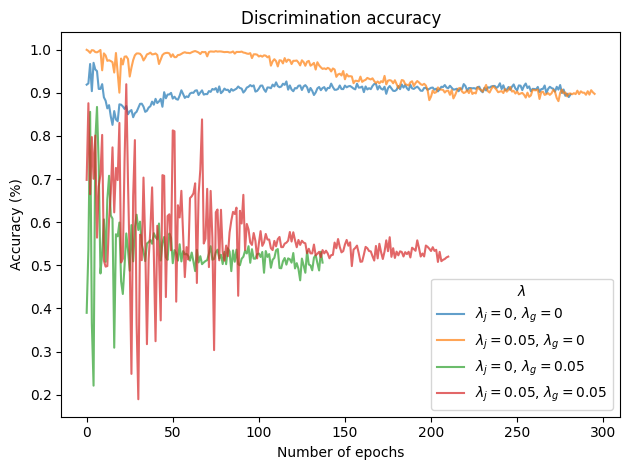

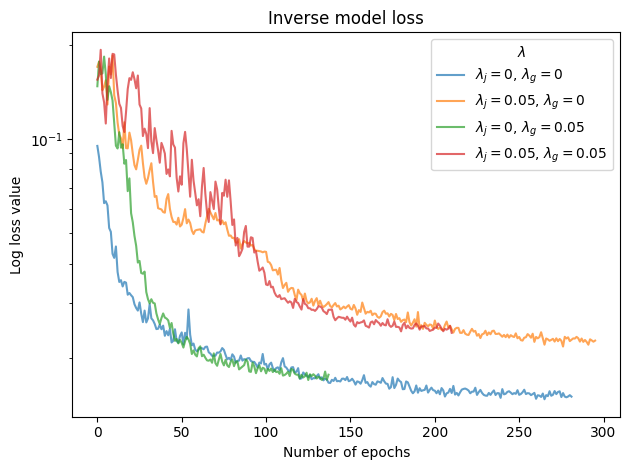

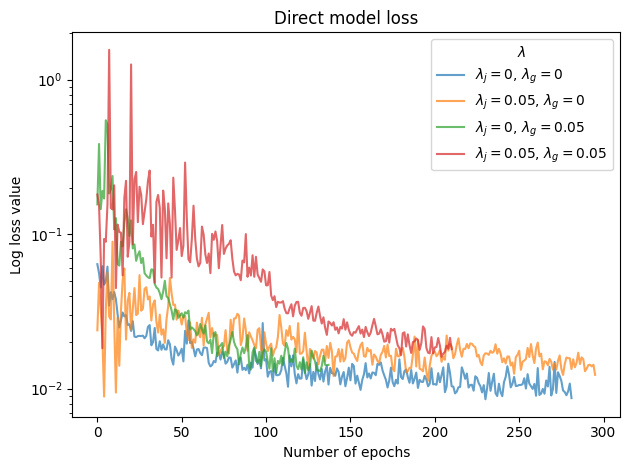

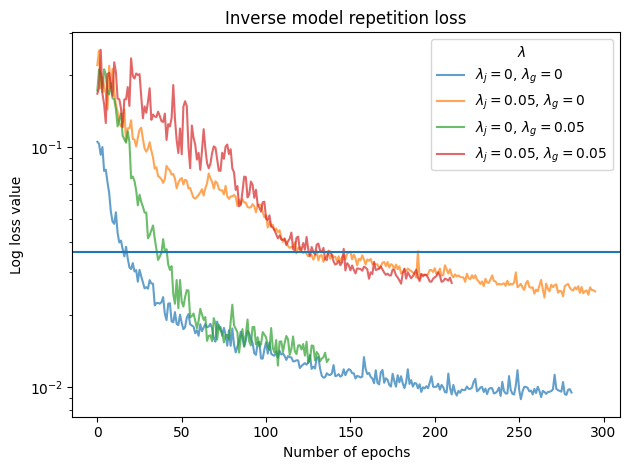

In [7]:
import matplotlib.pyplot as plt
for weight in WEIGHTS:
    jerk_loss_weight = weight.split('_')[0]
    discrimination_loss_weight = weight.split('_')[1]
    label = f'$\lambda_j = {jerk_loss_weight}$, $\lambda_g = {discrimination_loss_weight}$'
    plt.plot(losses['discrimination_accuracy'][weight], label=label, alpha=.7)
plt.legend(title='$\lambda$')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (%)")
plt.title("Discrimination accuracy")
plt.tight_layout()
plt.savefig("../out/communicative_agent/with_discriminator_discrimination_losses.png", dpi=300)
plt.show()

for weight in WEIGHTS:
    jerk_loss_weight = weight.split('_')[0]
    discrimination_loss_weight = weight.split('_')[1]
    label = f'$\lambda_j = {jerk_loss_weight}$, $\lambda_g = {discrimination_loss_weight}$'
    plt.plot(losses['inverse_model'][weight], label=label, alpha=.7)
plt.legend(title='$\lambda$')
plt.xlabel("Number of epochs")
plt.ylabel("Log loss value")
plt.title("Inverse model loss")
plt.yscale("log")
plt.tight_layout()
plt.savefig("../out/communicative_agent/with_discriminator_inverse_model_losses.png", dpi=300)
plt.show()

for weight in WEIGHTS:
    jerk_loss_weight = weight.split('_')[0]
    discrimination_loss_weight = weight.split('_')[1]
    label = f'$\lambda_j = {jerk_loss_weight}$, $\lambda_g = {discrimination_loss_weight}$'
    plt.plot(losses['direct_model'][weight], label=label, alpha=.7)
plt.legend(title='$\lambda$')
plt.xlabel("Number of epochs")
plt.ylabel("Log loss value")
plt.yscale("log")
plt.title("Direct model loss")
plt.tight_layout()
plt.savefig("../out/communicative_agent/with_discriminator_direct_model_losses.png", dpi=300)
plt.show()

for weight in WEIGHTS:
    jerk_loss_weight = weight.split('_')[0]
    discrimination_loss_weight = weight.split('_')[1]
    label = f'$\lambda_j = {jerk_loss_weight}$, $\lambda_g = {discrimination_loss_weight}$'
    plt.plot(losses['inverse_model_repetition'][weight], label=label, alpha=.7)
plt.axhline(0.0364)
plt.legend(title='$\lambda$')
plt.xlabel("Number of epochs")
plt.ylabel("Log loss value")
plt.yscale("log")
plt.title("Inverse model repetition loss")
plt.tight_layout()
plt.savefig("../out/communicative_agent/with_discriminator_inverse_model_repetition_losses.png", dpi=300)
plt.show()